# GPU accelerated eikonal solvers : reproducibility

In this notebook, we run CPU and GPU eikonal solvers, and check that they produce consistent results.

# 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")

In [2]:
import cupy as cp
import numpy as np
import time
from matplotlib import pyplot as plt

In [3]:
from agd import HFMUtils
from agd.HFMUtils import HFM_CUDA
from agd import AutomaticDifferentiation as ad

from agd.AutomaticDifferentiation.cupy_generic import cupy_get_args, decorate_module_functions, set_output_dtype32
norm_infinity = ad.Optimization.norm_infinity
from agd.HFMUtils import RunGPU,RunSmart

### 0.1 Decorations for gpu usage

In [4]:
cp = decorate_module_functions(cp,set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = decorate_module_functions(plt,cupy_get_args)
RunSmart = cupy_get_args(RunSmart,dtype64=True,iterables=(dict,))

In [5]:
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%5.3g" % x))

In [6]:
cp.ones(10)

Casting output of function ones from float64 to float32


array([    1,     1,     1,     1,     1,     1,     1,     1,     1,     1], dtype=float32)

# 1. Isotropic fast marching

In [7]:
def RunCompare(gpuIn):
    gpuOut = RunGPU(gpuIn)
    print("---")
    cpuOut = RunSmart(gpuIn)
    print("Norm of difference : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))
    cpuTime = cpuOut['FMCPUTime']; gpuTime = gpuOut['solverGPUTime'];
    print("Solver time (s). GPU {gpuTime}, CPU {cpuTime}, acceleration{cpuTime/gpuTime}")
    assert cp.allclose(gpuOut['values'],cpuOut['values'])
    return gpuOut,cpuOut

### 1.1 Three dimensions

In [8]:
n = 201
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    
})

TypeError: super() argument 1 must be type, not dictIn

### 1.2 Two dimensions

In [70]:
n=4001
hfmIn = HFMUtils.dictIn({
    'verbosity':2,
    'model':'Isotropic2',
    'arrayOrdering':'RowMajor',
    'seeds':[[0.,0.]],
    'exportValues':1,
    'tol':1e-6,
    'multiprecision':True,
#    'nitermax_o':22,
#    'traits':{
#        'pruning_macro':1,
#        'strict_iter_i_macro':1,
#        'strict_iter_o_macro':1,
#        'niter_i':16,'shape_i':(8,8),
#}
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
hfmIn['cost'] = cp.ones(hfmIn['dims'].astype(int))

X = hfmIn.Grid() # Coordinate system

Casting output of function ones from float64 to float32


In [47]:
RunGPU(hfmIn);

Setting the kernel traits.
(Scalar,Int,shape_i,niter_i,...)
key values_float64 defaults to False
key factoringRadius defaults to 0
key order defaults to 1
Prepating the domain data (shape,metric,...)
key periodic defaults to None
key overwriteMetric defaults to False
Preparing the values array (setting seeds,...)
key seedValues defaults to [    0]
key seedRadius defaults to 0.0
Preparing the GPU kernel
key dummy_kernel defaults to False
key cuoptions defaults to ()
Setup and run the eikonal solver
key solver defaults to AGSI
key nitermax_o defaults to 2000
GPU solve took 0.3369934558868408 seconds, in 334 iterations.
Post-Processing


In [71]:
gpuOut,cpuOut = RunCompare(hfmIn)

Setting the kernel traits.
(Scalar,Int,shape_i,niter_i,...)
key traits defaults to ()
key factoringRadius defaults to 0
key order defaults to 1
Prepating the domain data (shape,metric,...)
key periodic defaults to None
key overwriteMetric defaults to False
Preparing the values array (setting seeds,...)
key seedValues defaults to [    0]
key seedRadius defaults to 0.0
Preparing the GPU kernel
key dummy_kernel defaults to False
key cuoptions defaults to ()
Setup and run the eikonal solver
key solver defaults to AGSI
key nitermax_o defaults to 2000
GPU solve took 0.4875028133392334 seconds, in 334 iterations.
Post-Processing
key values_float64 defaults to False
---
Field order defaults to 1
Field seedRadius defaults to 0
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 12.019 s.
Field exportGeodesicFlow defaults to 0
***** Warning ! *****
Unused fields from user: multiprecision tol 
********************
Unused fields from compute : 

In [11]:
gpuOut

{'key used': ['verbosity',
  'model',
  'multiprecision',
  'dims',
  'gridScale',
  'cost',
  'seeds',
  'tol'],
 'key defaulted': [('traits', ()),
  ('factoringRadius', 0),
  ('order', 1),
  ('periodic', None),
  ('drift', None),
  ('speed', None),
  ('overwriteMetric', False),
  ('seedValues', array([    0], dtype=float32)),
  ('seedRadius', 0.0),
  ('dummy_kernel', False),
  ('cuoptions', ()),
  ('solver', 'AGSI'),
  ('nitermax_o', 2000),
  ('values_float64', False)],
 'key visited': ['gridScale'],
 'help content': {},
 'niter_o': 1230,
 'solverGPUTime': 9.20597767829895,
 'values': array([[ 1.42,  1.42,  1.42,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4, ...,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,  

In [12]:
cpuOut

{'FMCPUTime': 0.55,
 'GeodesicCPUTime': 0.0,
 'MaxStencilWidth': 1.0,
 'StencilCPUTime': 0.01,
 'defaulted': 'exportActiveNeighs exportActiveOffsets exportGeodesicFlow factoringMethod order refineStencilAtWallBoundary seedRadius showProgress',
 'nAccepted': 1002001.0,
 'unusedFromCompute': 'FMCPUTime GeodesicCPUTime MaxStencilWidth StencilCPUTime nAccepted values',
 'unusedFromUser': 'multiprecision tol',
 'unusedHelp': 'verbosity keyHelp arrayOrdering pointToIndex indexToPoint seeds seedValues seedRadius values FMCPUTime tips exportValues activeNeighs geodesicFlow',
 'values': array([[ 1.42,  1.42,  1.42,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,  1.41,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4,   1.4, ...,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,    

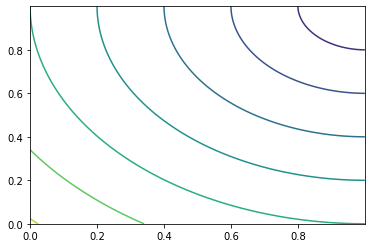

In [13]:
plt.contour(*X,gpuOut['values'])

In [14]:
hfmIn['cost']

array([[    1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1, ...,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1, ...,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1